# Fast & Sustainable Computational Biology: Vectorization, Indexing Tricks, and Numba/Cython

[![Jupyter Notebook](https://img.shields.io/badge/jupyter-%23FA0F00.svg?style=for-the-badge&logo=jupyter&logoColor=white)](https://github.com/LouisFaure/Blog_notebooks/blob/main/Efficient_code_python.ipynb)

Speeding up code is not typically a priority for researchers in computational biology. Numerous constraints (multiple projects, grant proposals, pressure to publish, etc.) often lead many to hastily write simple implementations of a given function, at the expense of efficiency. In this article, I will look at all tasks performed by a specific python function I have designed, showing first an example of slow code, and then a suggestion of a faster implementation. I hope this will provide some tips to you to perform a quicker, more efficient and [environmentally friendly](https://www.green-algorithms.org) science!

## The Task

During my research, I was assigned to implement a relatively simple function. We work with single-cell data that includes clonal barcodes. These barcodes allow us to group and identify cells that belong to the same lineage, as a barcode would be passed from the mother cell to all subsequent daughter cells. Clonal barcoding is a potent tool for studying early fate biasing and can be used as input for some tools to infer the fate of non-barcoded neighboring cells.

The most basic fate bias estimation between two fates, using only barcoded cells, consists in counting occurences of the fates in each clones, and use these occurences to assign a fate bias for each clone.

More precisely, we will calculate fate bias as following:
$$
f = \frac{f_A}{f_A+f_B} \times \frac{\alpha+1}{\alpha}
$$

with $f_A$ and $f_B$ being the number of occurence of our fates A and B in each clone, and the $\alpha= \frac{\sum f_A}{\sum f_B}$ ratio of the sum of all observed clones for each fate .

To test of significance of fate bias, we will perform a Fisher extact test, with a 2x2 contigency table:

$$
\begin{align*}
\begin{array}{|c|c|}
\hline
f_A & f_B \\
\hline
\sum f_A & \sum f_B \\
\hline
\end{array}
\end{align*}
$$


While this task should not be compute intensive, there are several good examples of slow and inefficient code that could be fixed. You will see that slowness is not only caused by slow calculation, but also data access!

### The system used for benchmark

The numbers showed here comes from tests with my MacBook Air M1 8GB.

I used python 3.10.13 and installed the following packages:

```bash
pip install cospar fast_fisher
```

## Loading libraries and the data

In [1]:
import cospar as cs
import warnings
import scanpy as sc
import numpy as np
import pandas as pd
import time
sc.set_figure_params()
warnings.filterwarnings('ignore')

### Quick overview of the data

The data we will use here is a 30k+ cells dataset of mouse hematopoiesis. The cells were clonally barcoded once and then were subsequently sampled at multiple time points.

In [2]:
adata_orig = cs.datasets.hematopoiesis()

We will focus on the bifurcation between Monocytes and Neutrophils:

In [3]:
mask=adata_orig.obs.state_info.isin(["Monocyte","Neutrophil"]) | adata_orig.obs.NeuMon_mask
adata=adata_orig[mask].copy()

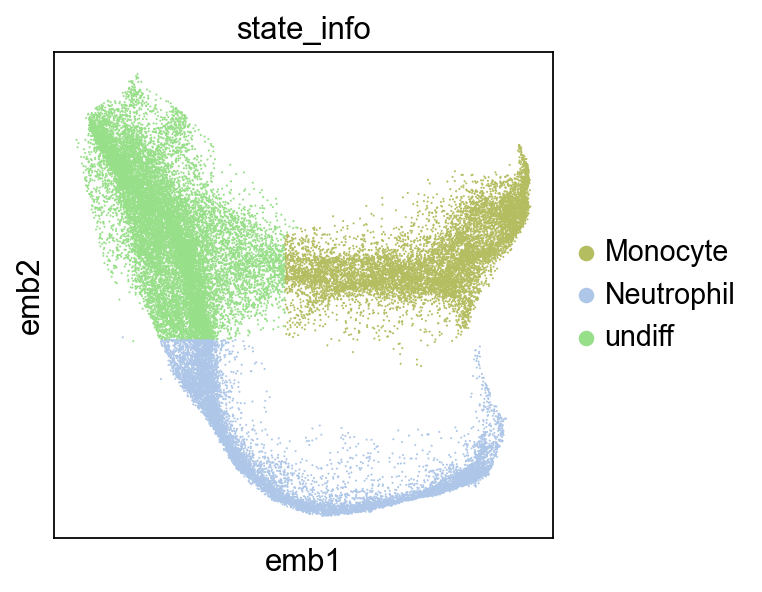

In [4]:
sc.pl.embedding(adata,color="state_info",basis="emb")

### Some parameters needed

In [5]:
clone='X_clone' # key to access the clonal matrix
fA='Neutrophil' # fate A
fB='Monocyte'   # fate B
state_key='state_info' # key for fate assignments
cutoff=0.01 # cutoff for Fisher test corrected p-values

## Getting cell indices for each clone
We use a clone matrix saved in anndata under `obsm`, where the rows are cells and columns are clones. We need to extract which cell belong to which clone. In other words, the task is to retrieve row indices of each column.

In [6]:
def get_cellid_per_clone(adata,clone):
    X_clone=adata.obsm[clone]
    return [np.argwhere(X_clone[:,i])[:,0] for i in range(X_clone.shape[1])]

In [7]:
start = time.time()
cid = get_cellid_per_clone(adata,clone)
end = time.time()
print(f'{(end-start):.3}s')

0.815s


Why is this method slow? Though this approach is simple and straightforward (practically one line), a `for` loop that calls `np.argwhere` for each of the columns implies that we are not leveraging numpy's ability to perform operations on entire arrays at once.

Let's have a look at a faster implementation:

In [8]:
def get_cellid_per_clone_f(adata,clone):
    X_clone=adata.obsm[clone]
    # Extract and sort row and columns
    rows, cols = np.nonzero(X_clone)
    sort_idx = np.argsort(cols)
    rows_sorted = rows[sort_idx]
    cols_sorted = cols[sort_idx]
    # Get the count of unique columns
    _, counts = np.unique(cols_sorted, return_counts=True)
    # Split rows_sorted based on counts
    return np.split(rows_sorted, np.cumsum(counts[:-1]))

In [9]:
start = time.time()
cid = get_cellid_per_clone_f(adata,clone)
end = time.time()
print(f'{(end-start):.3}s')

0.00611s


Why is this fast? Because we use numpy's vectorized function `np.nonzero` to find the indices of non-zero elements in the entire array at once. Then, we sort these indices based on the column indices and splits them into separate arrays for each column. By sorting the indices based on the column indices (`np.argsort` is also vectorized), the function avoids having to access the columns individually. 

## Getting occurence of our two fate labels in each clone

We want to count the occurence of our two fate labels in each clone and the total of each fate. This involves to retrieve the cluster assignment for each cell within each clone.

In [10]:
def get_counts_per_clone(adata,cid,state_key):
    # Convert cell id to assigned cell state for each clone
    cl=[adata[c].obs[state_key] for c in cid]
    # Count occurences of states per clone
    clA=np.array([(c==fA).sum() for c in cl])
    clB=np.array([(c==fB).sum() for c in cl])
    clAsum, clBsum = np.sum(clA) , np.sum(clB)
    return clA, clB, clAsum, clBsum

In [11]:
start = time.time()
clA, clB, clAsum, clBsum = get_counts_per_clone(adata,cid,state_key)
end = time.time()
print(f'{(end-start):.3}s')

2.01s


Why is this slow? Here the issue lies on the repeated access of the anndata object in a `for` loop, which is not very efficient. Also, although this does not have that much of an impact, the function calculates the sum of clA and clB separately.

Here is a faster implementation:

In [12]:
def get_counts_per_clone_f(adata,cid,state_key):
    # Get cell id and clone id array
    i = np.repeat(np.arange(len(cid)), [len(c) for c in cid])
    c = np.concatenate(cid)
    cid_cl = np.column_stack((c, i))
    # apply cell/clone id array to states array
    df = adata.obs[[state_key]]
    df["clone"]=np.nan
    df.iloc[cid_cl[:,0],1]=cid_cl[:,1]
    # Count occurences of states per clone
    cnts=df.groupby(state_key).value_counts(["clone"])
    clAB=pd.concat([cnts[fA].sort_index(),cnts[fB].sort_index()],axis=1).values
    clA, clB = clAB[:,0], clAB[:,1]
    clAsum, clBsum = clAB.sum(axis=0)
    return clA, clB, clAsum, clBsum

In [13]:
start = time.time()
clA, clB, clAsum, clBsum = get_counts_per_clone_f(adata,cid,state_key)
end = time.time()
print(f'{(end-start):.3}s')

0.0169s


Why is this fast? First, we used vectorized functions `np.column_stack` and `np.repeat` to create a numpy array assigning each cell index to a clone id. Then, we use the `groupby` method from pandas, which is optimized for grouping and aggregating data. Finally, the anndata is read and writen only once, avoiding the usage of any `for` loop.

## Calculating fate bias and its significance per cell
We will use the equation mentionned in the introduction, as well as Fisher exact test. More precisley, we will perform the test on each clone using extracted counts of our two fates and their total sum.

In [14]:
def get_fate_bias(clA,clB,clAsum, clBsum):
    # Perform Fisher extact test on clone counts
    from scipy.stats import fisher_exact
    pvals = [fisher_exact(np.array([[cla,clb], [clAsum, clBsum]]))[1] 
             for cla,clb in zip(clA,clB)]
    # Get fate biasing using clone counts
    slope=clAsum/clBsum
    fate_bias=(clA/(clA+clB))*((slope+1)/slope)
    fate_bias=fate_bias/np.nanmax(fate_bias)
    return pvals, slope, fate_bias

In [15]:
start = time.time()
pvals, slope, fate_bias = get_fate_bias(clA,clB,clAsum, clBsum)
end = time.time()
print(f'{(end-start):.3}s')

1.11s


Why is this slow? Because `scipy` implementation of `fisher_exact` is writen in plain python. As this is the actual calculation part of our code, there should be room for improvement by using a faster implementation:

In [16]:
def get_fate_bias_f(clA,clB,clAsum, clBsum):
    # Perform Fisher extact test on clone counts
    from fast_fisher import fast_fisher_exact 
    pvals = [fast_fisher_exact(cla,clb, clAsum, clBsum) 
             for cla,clb in zip(clA,clB)]
    # Get fate biasing using clone counts
    slope=clAsum/clBsum
    fate_bias=(clA/(clA+clB))*((slope+1)/slope)
    fate_bias=fate_bias/np.nanmax(fate_bias)
    return pvals, slope, fate_bias

In [17]:
start = time.time()
pvals, slope, fate_bias = get_fate_bias_f(clA,clB,clAsum, clBsum)
end = time.time()
print(f'{(end-start):.3}s')

0.00617s


Why is this fast? With simple google search, I found the python package [fast_fisher](https://github.com/MrTomRod/fast-fisher), which provides numba and cython implementations of the Fisher exact test. Numba compiles a function using LLVM compiler library, while Cython convert Python functions to compiled C code, both lead to great speedups.

## Saving the data
One might think that saving data is a trivial task. Here is how to avoid inefficiencies!

In [18]:
def assign_results(adata,cid,pvals,fate_bias,cutoff):
    adata.obs["fisher_pval"] = np.nan
    adata.obs["fate_bias"] = 0.5
    for ci,p,f in zip(cid,pvals,fate_bias):
        adata.obs.loc[adata.obs_names[ci],'fisher_pval']=p
        if p < cutoff:
            adata.obs.loc[adata.obs_names[ci],'fate_bias']=f

In [19]:
start = time.time()
assign_results(adata,cid,pvals,fate_bias,cutoff)
end = time.time()
print(f'{(end-start):.3}s')

0.398s


Why is this slow? The function locates the index of the dataframe using `adata.obs_names[ci]` and assigns the values. This operation is not very efficient as it involves looking up the index for each individual element. In addition, `loc` is slow as the cell id needs to be converted into integer indexes.

In [20]:
def assign_results_f(adata,cid,pvals,fate_bias,cutoff):
    adata.obs["fisher_pval"] = np.nan
    adata.obs["fate_bias"] = 0.5
    c = np.concatenate(cid)
    # prepare assignment array
    cid_len = np.array([len(c) for c in cid])
    cid_pval_f = np.column_stack((
        c, np.repeat(pvals, cid_len), 
        np.repeat(fate_bias, cid_len)
    ))
    
    # assign values to anndata
    col=adata.obs.columns
    adata.obs.iloc[cid_pval_f[:,0],col=="fisher_pval"]=cid_pval_f[:,1]
    cid_pval_f = cid_pval_f[cid_pval_f[:,1]<cutoff,:]
    adata.obs.iloc[cid_pval_f[:,0].astype(int),col=="fate_bias"]=cid_pval_f[:,2]  

In [21]:
start = time.time()
assign_results_f(adata,cid,pvals,fate_bias,cutoff)
end = time.time()
print(f'{(end-start):.3}s')

0.00743s


Why is this fast? We prepare the assignment array outside the loop, which reduces the computational overhead. This assignment arrayis created by vectorized functions `np.repeat` and `np.column_stack`. To perform the actual assignment, we use `iloc` for indexing, which is faster than `loc` because it accesses the data directly by integer index. Lastly, we use boolean indexing (`cid_pval_f[:,1]<cutoff`) to filter the data, which is more efficient than using a loop.

## Overall speed comparison

In [22]:
def slow_implementation(
    adata,
    clone='X_clone',
    fA='Neutrophil',
    fB='Monocyte',
    state_key='state_info',
    cutoff=0.01):
    
    cid = get_cellid_per_clone(adata,clone)
    clA, clB, clAsum, clBsum = get_counts_per_clone(adata,cid,state_key)
    pvals, slope, fate_bias = get_fate_bias(clA,clB,clAsum, clBsum)
    assign_results(adata,cid,pvals,fate_bias,cutoff)


def fast_implementation(
    adata,
    clone='X_clone',
    fA='Neutrophil',
    fB='Monocyte',
    state_key='state_info',
    cutoff=0.01):
    
    cid = get_cellid_per_clone_f(adata,clone)
    clA, clB, clAsum, clBsum = get_counts_per_clone_f(adata,cid,state_key)
    pvals, slope, fate_bias = get_fate_bias_f(clA,clB,clAsum, clBsum)
    assign_results_f(adata,cid,pvals,fate_bias,cutoff)

In [23]:
start = time.time()
slow_implementation(adata)
end = time.time()
slow_t=(end-start)

fate_bias_slow=adata.obs.fate_bias.copy()
pvals_slow=adata.obs.fisher_pval.copy()

start = time.time()
fast_implementation(adata)
end = time.time()
fast_t=(end-start)

fate_bias_fast=adata.obs.fate_bias.copy()
pvals_fast=adata.obs.fisher_pval.copy()

print(f'{(slow_t/fast_t):.4}X speed improvement!')

239.9X speed improvement!


We achieved more than a 200X speed improvement! That is quite an accomplishment. It's important to note that the slower code benefited from the fast SSD of my MacBook. I would anticipate it running much slower on a system/HPC with slower storage.

### Checking consistency between two approaches
It is always important to check that you end up in the same result between the two implementation!

In [24]:
np.array_equal(fate_bias_slow,fate_bias_fast)

True

In [25]:
# Using allclose because of slight numerical differences 
# between python and C implementations
np.allclose(pvals_fast,pvals_slow) 

True

## Displaying results

Let's display our extracted fate biases

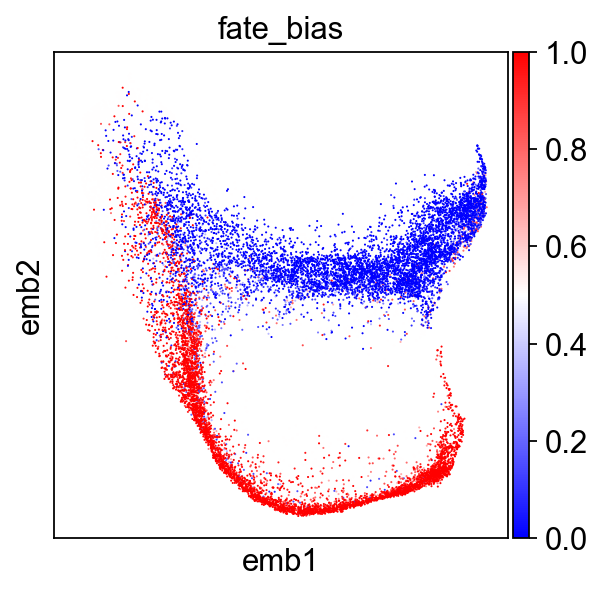

In [26]:
sc.pl.embedding(adata[(adata.obs.fate_bias-.5).abs().sort_values().index],
                color="fate_bias",basis="emb",sort_order=False,cmap='bwr')

## Some tips for efficient code writing and sharing

- Before attempting to parallelize every possible for loop, try to vectorize your code as much as possible. Numpy provides a wide range of fast functions for this purpose.
- Be mindful of data read/write and indexing, especially on slower HDD systems. Sometimes, pre-allocating data arrays and/or sorting indexes can be beneficial strategies.
- For actual computations, use Numba or Cython implementations whenever possible. Writing in Numba is particularly straightforward as its syntax is identical to Python's.
- Don't hesitate to explore the web or ask some LLMs. There's a good chance someone has already implemented a particular subfunction you need!
- Identify the slow parts of your code by profiling the runtime line by line. A simple and effective tool for this task is [line_profiler](https://github.com/pyutils/line_profiler).

However, there's an important caveat:
- Don't waste your time optimizing a code/function that isn't expected to be used frequently or by many people. It's crucial to assess where our time is best invested!


## Why is this important?

Writing fast and optimized code is crucial in computational biology for several reasons. Firstly, efficient code reduces the energy consumption of computational processes, which not only minimizes costs but also lessens the carbon footprint, leading to more environmentally friendly operations. Secondly, this allows for quicker data processing and results generation (and less coffee converted into code!), enabling scientists to make discoveries more rapidly. This speed is particularly vital when dealing with the ever growing size and complexity of data sets. Finally, when such optimized code is released publicly, its benefits are compounded: Other scientists will leverage the same efficiency and speed in their own research, accelerating scientific progress across the board and further reducing CO2 emissions!